In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math

In [2]:
data = pd.read_csv('./dataset.csv', index_col = 'Date')
data = data.iloc[:3000, :]
data

,Close,High,Low,Open,Volume,7ma,14ma,21ma,7macd,14macd,...,SMH,SOXX,TSM,XLK,^DJI,^GSPC,^IRX,^IXIC,^TNX,^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,0.089091,0.090466,0.087716,0.088862,7.244040e+08,0.085997,0.090707,0.096837,0.006344,0.013478,...,12.879367,12.922947,3.433685,13.992236,10040.820312,1091.229980,1.442,1819.890015,4.211,16.959999
2004-08-20,0.094363,0.095661,0.088326,0.088633,1.199040e+09,0.088089,0.091195,0.096612,0.004371,0.012817,...,12.900661,13.010767,3.470857,14.060058,10110.139648,1098.349976,1.454,1838.020020,4.231,16.000000
2004-08-23,0.096426,0.097419,0.095356,0.095891,8.000280e+08,0.090173,0.091892,0.096595,0.002490,0.011964,...,13.032693,13.142493,3.508028,14.127869,10073.049805,1095.680054,1.477,1838.699951,4.279,15.880000
2004-08-24,0.092835,0.098260,0.091001,0.097801,9.394200e+08,0.090839,0.092018,0.096253,0.001277,0.011091,...,12.726041,12.857079,3.456918,14.052525,10098.629883,1096.189941,1.517,1836.890015,4.283,15.330000
2004-08-25,0.096807,0.097495,0.093140,0.094898,7.213080e+08,0.092331,0.092656,0.096304,0.000167,0.010142,...,12.875108,12.991554,3.568431,14.210758,10181.740234,1104.959961,1.512,1860.719971,4.261,14.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-17,2.490181,2.541655,2.476882,2.536729,5.806120e+08,2.554063,2.560080,2.532888,0.007915,-0.082849,...,33.323589,37.547466,23.808977,45.091431,19826.769531,2267.889893,0.513,5538.729980,2.327,11.870000
2017-01-18,2.535498,2.542394,2.440925,2.468755,6.544240e+08,2.549422,2.556802,2.533125,0.012956,-0.073976,...,33.913143,38.060070,23.704485,45.209915,19804.720703,2271.889893,0.515,5555.649902,2.389,12.480000
2017-01-19,2.589927,2.621944,2.536237,2.538454,6.448720e+08,2.559548,2.561219,2.538289,0.010601,-0.066947,...,33.655220,37.889202,23.817015,45.146107,19732.400391,2263.689941,0.503,5540.080078,2.459,12.780000


In [3]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [4]:
data.shape

(2988, 53)

In [5]:
data['y'] = data['Close']
data.drop(['Close'], axis = 1, inplace = True)
data.head()

,High,Low,Open,Volume,7ma,14ma,21ma,7macd,14macd,7rsi,...,SOXX,TSM,XLK,^DJI,^GSPC,^IRX,^IXIC,^TNX,^VIX,y
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,0.090466,0.087716,0.088862,7.244040e+08,0.085997,0.090707,0.096837,0.006344,0.013478,166.973821,...,12.922947,3.433685,13.992236,10040.820312,1091.229980,1.442,1819.890015,4.211,16.959999,0.089091
2004-08-20,0.095661,0.088326,0.088633,1.199040e+09,0.088089,0.091195,0.096612,0.004371,0.012817,118.715025,...,13.010767,3.470857,14.060058,10110.139648,1098.349976,1.454,1838.020020,4.231,16.000000,0.094363
2004-08-23,0.097419,0.095356,0.095891,8.000280e+08,0.090173,0.091892,0.096595,0.002490,0.011964,105.508705,...,13.142493,3.508028,14.127869,10073.049805,1095.680054,1.477,1838.699951,4.279,15.880000,0.096426
2004-08-24,0.098260,0.091001,0.097801,9.394200e+08,0.090839,0.092018,0.096253,0.001277,0.011091,136.967726,...,12.857079,3.456918,14.052525,10098.629883,1096.189941,1.517,1836.890015,4.283,15.330000,0.092835
2004-08-25,0.097495,0.093140,0.094898,7.213080e+08,0.092331,0.092656,0.096304,0.000167,0.010142,122.468020,...,12.991554,3.568431,14.210758,10181.740234,1104.959961,1.512,1860.719971,4.261,14.980000,0.096807


In [6]:

x = data.iloc[:, :52].values
y = data.iloc[:,52].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2390, 52) trainY: (2390,)
testX: (598, 52) testY: (598,)


In [7]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [8]:
train_x_tensor, train_y_tensor, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_tensor, test_y_tensor, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_tensor.shape} train_y: {train_y_tensor.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_tensor.shape} test_y: {test_y_tensor.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([2387, 3, 52]) train_y: torch.Size([2387, 1]) train_y_gan: torch.Size([2387, 4, 1])
test_x: torch.Size([595, 3, 52]) test_y: torch.Size([595, 1]) test_y_gan: torch.Size([595, 4, 1])


In [9]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 512, batch_first=True)
        self.lstm_2 = nn.LSTM(512, 256, batch_first=True)
        self.lstm_3 = nn.LSTM(256, 128, batch_first=True)
        self.linear_1 = nn.Linear(128, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1 = self.dropout(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2 = self.dropout(out_2)
        out_3, _ = self.lstm_3(out_2)
        out_3 = self.dropout(out_3)
        out = out_3[:, -1, :]
        out = self.linear_1(out)
        out = self.linear_2(out)
        out = self.linear_3(out)

        return out


In [10]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.0001
num_epochs = 200
clip_value = 1.0
patience = 20

trainDataloader = DataLoader(TensorDataset(train_x_tensor, train_y_tensor),batch_size=batch_size, shuffle=False)

model = LSTM(52).to(device)
print(model)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

hist = np.zeros(num_epochs)
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    loss_ = []

    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        loss_.append(loss.item())

    epoch_loss = np.mean(loss_)
    hist[epoch] = epoch_loss
    print(f'[{epoch+1}/{num_epochs}] Loss: {epoch_loss:.6f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

LSTM(
  (lstm_1): LSTM(52, 512, batch_first=True)
  (lstm_2): LSTM(512, 256, batch_first=True)
  (lstm_3): LSTM(256, 128, batch_first=True)
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)
[1/200] Loss: 0.077483
[2/200] Loss: 0.040998
[3/200] Loss: 0.027052
[4/200] Loss: 0.024525
[5/200] Loss: 0.022726
[6/200] Loss: 0.020176
[7/200] Loss: 0.017246
[8/200] Loss: 0.013051
[9/200] Loss: 0.007704
[10/200] Loss: 0.004686
[11/200] Loss: 0.004434
[12/200] Loss: 0.003050
[13/200] Loss: 0.003504
[14/200] Loss: 0.005688
[15/200] Loss: 0.002143
[16/200] Loss: 0.003458
[17/200] Loss: 0.002399
[18/200] Loss: 0.005252
[19/200] Loss: 0.003027
[20/200] Loss: 0.003306
[21/200] Loss: 0.003790
[22/200] Loss: 0.001699
[23/200] Loss: 0.002363
[24/200] Loss: 0.001769
[25/200] Loss: 0.003198
[26/200] Loss: 0.001843
[2

In [11]:
model.eval()
pred_y_train = model(train_x_tensor.to(device))
pred_y_test = model(test_x_tensor.to(device))

y_train_true = y_scaler.inverse_transform(train_y_tensor)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_tensor)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.019266891364383632, R2: 0.9817819738580471


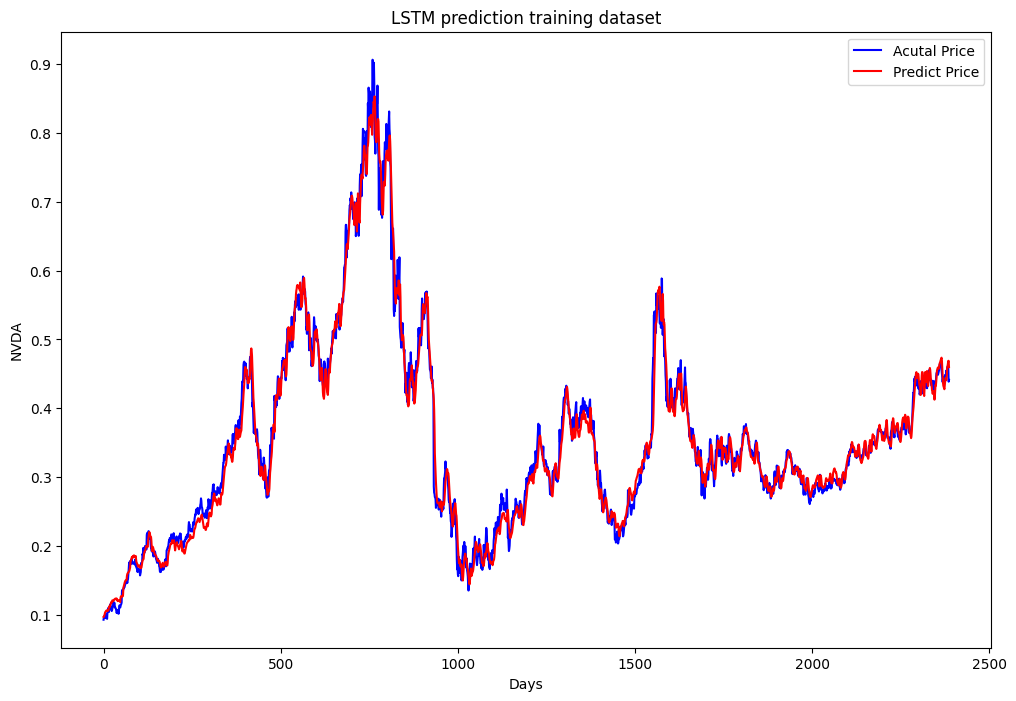

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'red', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('NVDA')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_train_true, y_train_pred)
print(f'Training dataset RMSE:{RMSE}, R2: {R2}')

Training dataset RMSE:0.3778914811236345, R2: 0.5684456644853171


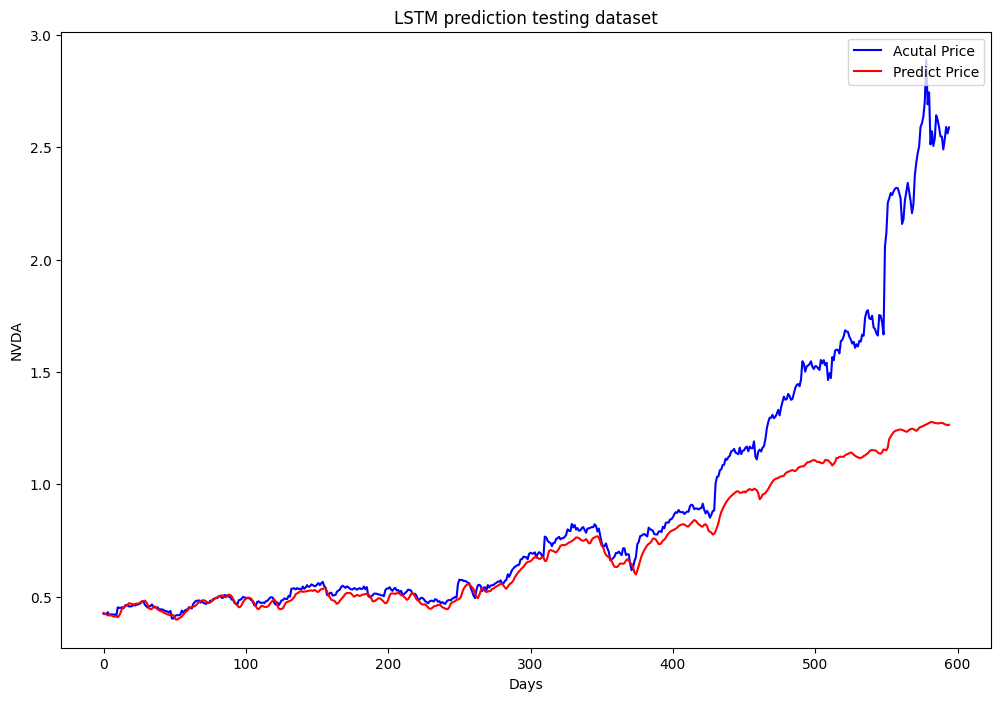

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'red', label = 'Predict Price')
plt.title('LSTM prediction testing dataset')
plt.ylabel('NVDA')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test_true, y_test_pred)
print(f'Training dataset RMSE:{RMSE}, R2: {R2}')